# Self gravitating Plummer Sphere

In [1]:
import os
from math import pi

# os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Use only the first GPU
from autocvd import autocvd
autocvd(num_gpus = 1)
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc
from odisseo.option_classes import SimulationConfig, SimulationParams, NFWParams, PlummerParams, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif,create_3d_gif_velocitycoding, create_projection_gif, energy_angular_momentum_plot


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=100_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1, 
                          external_accelerations=(), 
                          softening=(0.1*u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=100000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=1, softening=np.float64(0.010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=0, batch_size=10000, double_map=False, external_accelerations=(), differentation_mode=1, num_checkpoints=100, progress_bar=False, gradient_horizon=0)
SimulationParams(G=1, t_end=np.float64(0.6707087409203456), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(M=4501365375.06545, alpha=1.8, r_c=1.9), Logarithmic_params=LogarithmicParams(v0=220.0, q=0.9))


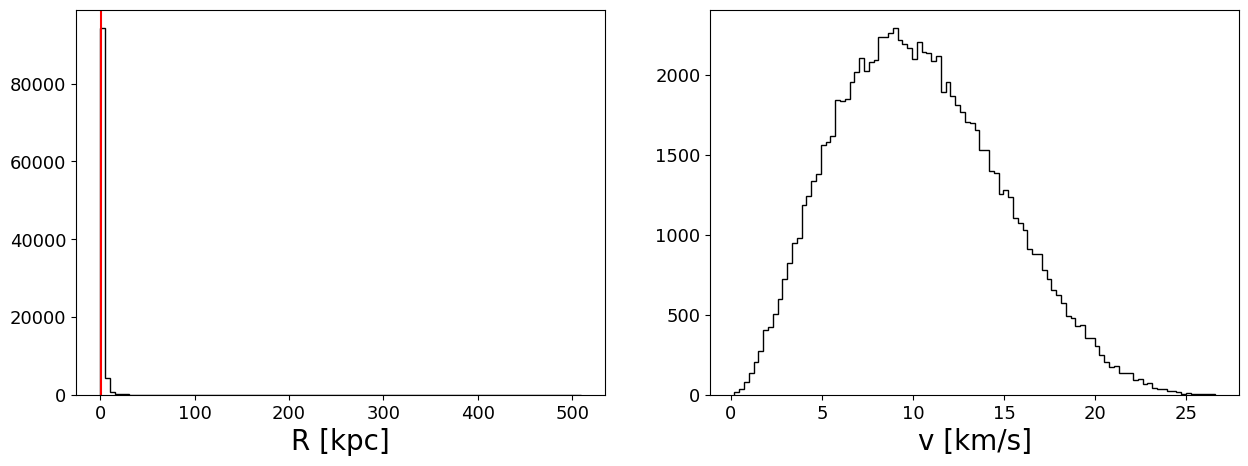

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [38]:
if config.return_snapshots: 
    snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))
else:
    final_state = jax.block_until_ready(time_integration(initial_state, mass, config, params))


2025-09-25 16:06:46.354249: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 7.10GiB (7624605174 bytes) by rematerialization; only reduced to 84.84GiB (91097604120 bytes), down from 84.84GiB (91097604184 bytes) originally
2025-09-25 16:06:57.072465: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 84.39GiB (rounded to 90612801792)requested by op 
2025-09-25 16:06:57.072742: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] *******_____________________________________________________________________________________________
E0925 16:06:57.072790 1903651 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 90612801624 bytes. [tf-allocator-allocation-error='']


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 90612801624 bytes.

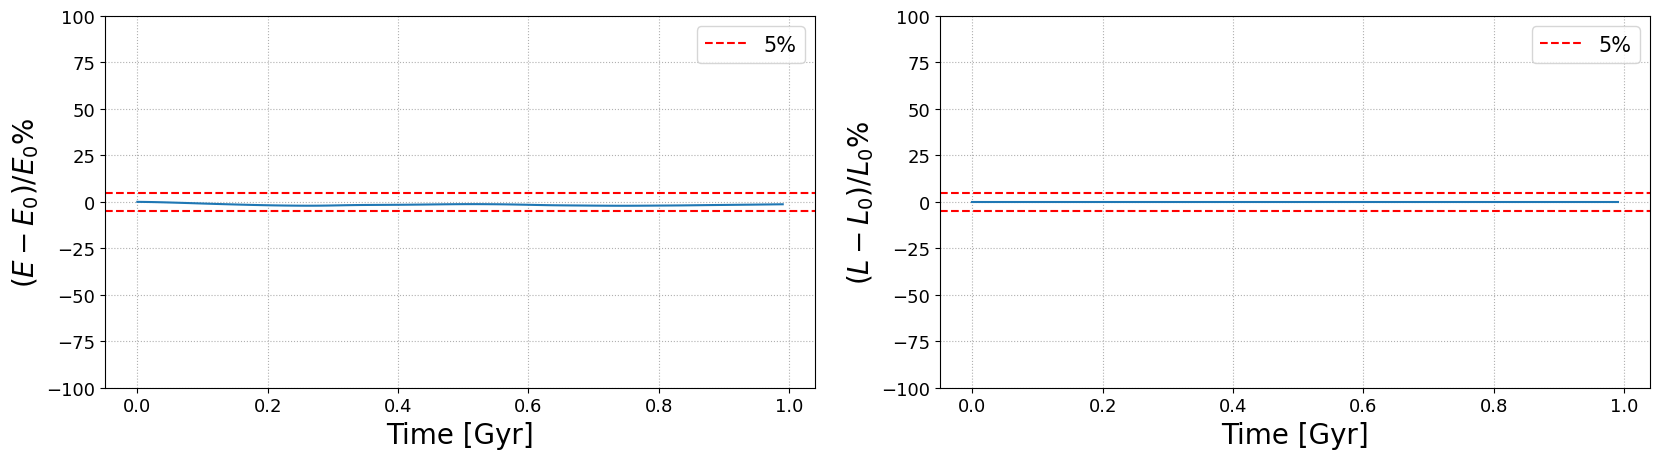

In [6]:
energy_angular_momentum_plot(snapshots, code_units, )

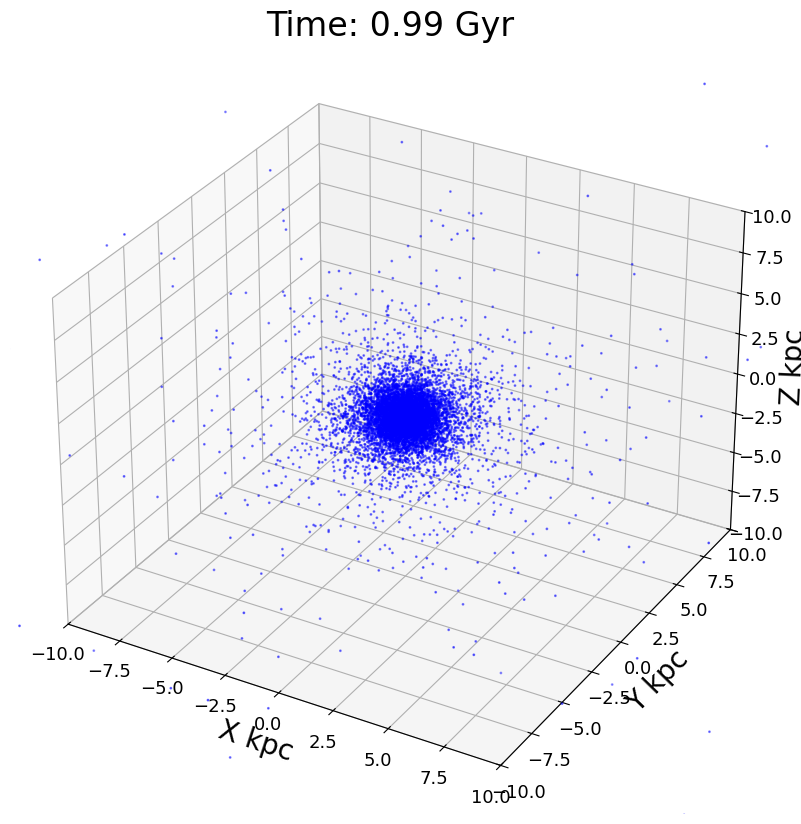

In [ ]:
create_3d_gif(snapshots, 
              ax_lim=(10*params.Plummer_params.a*code_units.code_length).value, 
              code_units=code_units, 
              plotting_units_length=u.kpc, 
              plot_units_time=u.Gyr, 
            #   filename='./visualization/gif/simulation_Plummer.gif'
            )

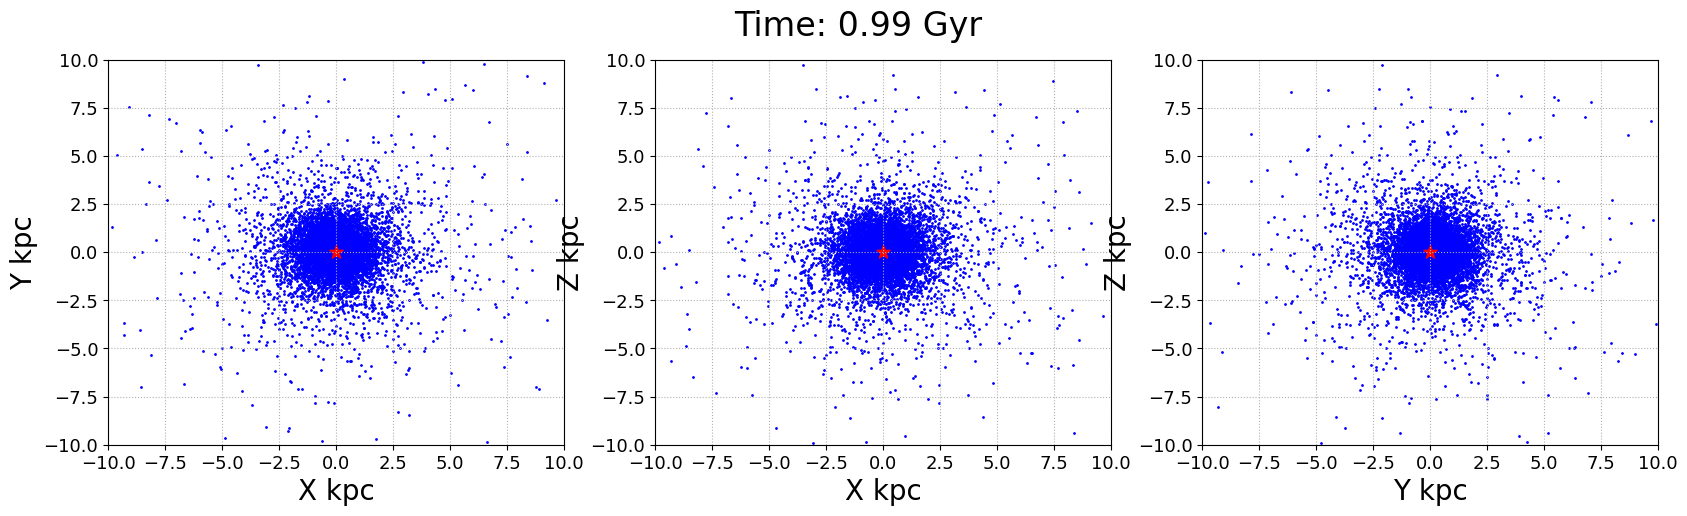

In [ ]:
create_projection_gif(snapshots=snapshots,
                      ax_lim=(10*params.Plummer_params.a*code_units.code_length).value,  
                      code_units=code_units, 
                      plotting_units_length=u.kpc, 
                      plot_units_time=u.Gyr, 
                    #   filename='./visualization/gif/simulation_projection_Plummer.gif')

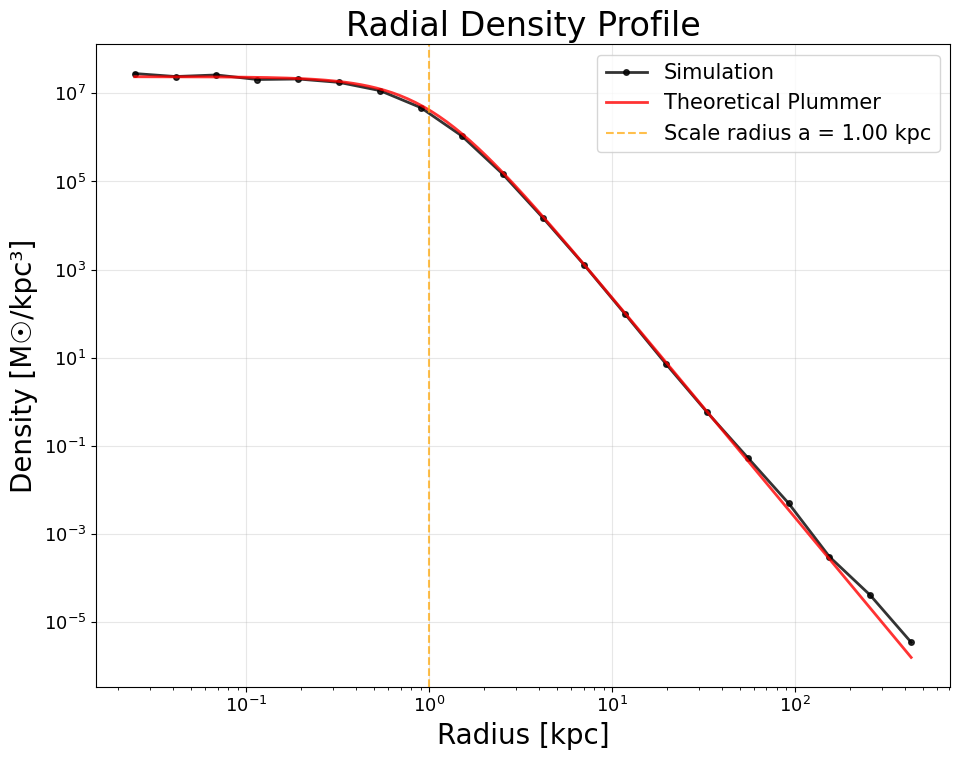

In [5]:
def calculate_radial_density_profile(final_snapshot, mass, code_units, 
                                   r_min=None, r_max=None, n_bins=50, 
                                   plotting_units=u.kpc):
    """
    Calculate 3D radial density profile from particle positions
    
    Parameters:
    -----------
    final_snapshot : array (N_particles, 2, 3)
        Final state with positions and velocities
    mass : array (N_particles,)
        Mass of each particle
    code_units : CodeUnits
        Unit conversion object
    r_min, r_max : float, optional
        Min/max radii for binning (in code units)
    n_bins : int
        Number of radial bins
    plotting_units : astropy.units
        Units for output (e.g., u.kpc)
    
    Returns:
    --------
    r_centers : array
        Radial bin centers
    density : array
        Density in each bin
    """
    
    # Extract positions (first index of second dimension)
    positions = final_snapshot[:, 0, :]  # Shape: (N_particles, 3)
    
    # Calculate radial distances from origin
    radii = jnp.linalg.norm(positions, axis=1)  # Shape: (N_particles,)
    
    # Set default r_min and r_max if not provided
    if r_min is None:
        r_min = jnp.min(radii[radii > 0])   # Avoid r=0
    if r_max is None:
        r_max = jnp.max(radii) * 1.1
    
    # Create logarithmic bins (better for wide dynamic range)
    r_bins = jnp.logspace(jnp.log10(r_min), jnp.log10(r_max), n_bins + 1)
    r_centers = jnp.sqrt(r_bins[:-1] * r_bins[1:])  # Geometric mean
    
    # Calculate mass in each radial shell
    mass_in_shell = jnp.zeros(n_bins)
    
    for i in range(n_bins):
        # Find particles in this radial shell
        in_shell = (radii >= r_bins[i]) & (radii < r_bins[i+1])
        mass_in_shell = mass_in_shell.at[i].set(jnp.sum(mass[in_shell]))
    
    # Calculate shell volumes (4π * r² * dr)
    shell_volumes = (4.0 * jnp.pi / 3.0) * (r_bins[1:]**3 - r_bins[:-1]**3)
    
    # Calculate density (mass / volume)
    density = mass_in_shell / shell_volumes
    
    # Convert to physical units
    r_centers_physical = (r_centers * code_units.code_length).to(plotting_units)
    density_physical = (density * code_units.code_mass / code_units.code_length**3).to(u.Msun / u.kpc**3)
    
    return r_centers_physical, density_physical, r_bins

# Usage example:
r_centers, density, r_bins = calculate_radial_density_profile(
    initial_state, mass, code_units, 
    n_bins=20, plotting_units=u.kpc
)

def plot_density_profile(r_centers, density, params, code_units):
    """Plot the density profile with theoretical Plummer profile"""
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot calculated density
    ax.loglog(r_centers, density, 'ko-', markersize=4, linewidth=2, 
              label='Simulation', alpha=0.8)
    
    # Theoretical Plummer density profile
    def plummer_density(r, M_total, a):
        """Theoretical Plummer density profile"""
        rho_0 = (3 * M_total) / (4 * jnp.pi * a**3)
        return rho_0 * (1 + (r/a)**2)**(-5/2)
    
    # Calculate theoretical profile
    M_total_phys = (params.Plummer_params.Mtot * code_units.code_mass).to(u.Msun)
    a_phys = (params.Plummer_params.a * code_units.code_length).to(u.kpc)
    
    # r_theory = jnp.logspace(-2, 2, 100) * u.kpc
    r_theory = jnp.logspace(jnp.log10(r_centers.min().value), jnp.log10(r_centers.max().value), 200) * u.kpc
    rho_theory = plummer_density(r_theory.value, M_total_phys.value, a_phys.value) * u.Msun / u.kpc**3
    
    ax.loglog(r_theory, rho_theory, 'r-', linewidth=2, 
              label='Theoretical Plummer', alpha=0.8)
    
    # Mark the scale radius
    ax.axvline(a_phys.value, color='orange', linestyle='--', alpha=0.7,
               label=f'Scale radius a = {a_phys:.2f}')
    
    ax.set_xlabel('Radius [kpc]')
    ax.set_ylabel('Density [M☉/kpc³]')
    ax.set_title('Radial Density Profile')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Plot the results
fig = plot_density_profile(r_centers, density, params, code_units)

In [8]:
import jax.scipy.stats as jss

def differentiable_density_profile_jax_kde(final_snapshot, mass, code_units, 
                                          r_eval=None, n_eval=100, 
                                          bw_method=None, plotting_units=u.kpc):
    """
    Differentiable radial density profile using jax.scipy.stats.gaussian_kde
    
    Parameters:
    -----------
    final_snapshot : array (N_particles, 2, 3)
        Final state with positions and velocities
    mass : array (N_particles,)
        Particle masses (used as weights)
    code_units : CodeUnits
        Unit conversion object
    r_eval : array, optional
        Radii at which to evaluate density
    n_eval : int
        Number of evaluation points if r_eval not provided
    bw_method : str or float, optional
        Bandwidth selection method ('scott', 'silverman', or float)
    plotting_units : astropy.units
        Units for output
    
    Returns:
    --------
    r_eval_phys : array
        Evaluation radii in physical units
    density_phys : array
        Density at each evaluation radius in physical units
    kde : gaussian_kde object
        The fitted KDE object (differentiable)
    """
    
    # Extract positions and calculate radial distances
    positions = initial_state[:, 0]
    radii = jnp.linalg.norm(positions, axis=1)  # Shape: (N_particles,)
    
    # Create evaluation points if not provided
    if r_eval is None:
        r_min = jnp.min(radii[radii > 0]) 
        r_max = jnp.max(radii) 
        r_eval = jnp.logspace(jnp.log10(r_min), jnp.log10(r_max), n_eval)
    
    # Create the KDE using radial distances and particle masses as weights
    # Note: gaussian_kde expects shape (n_features, n_samples)
    dataset = radii.reshape(1, -1)  # Shape: (1, N_particles) for 1D data
    
    # Create weighted KDE
    kde = jss.gaussian_kde(dataset, bw_method=bw_method, weights=mass)
    
    # Evaluate the KDE at the desired radii
    # Note: we need to reshape r_eval for the kde
    r_eval_reshaped = r_eval.reshape(1, -1)  # Shape: (1, n_eval)
    density_1d = kde(r_eval_reshaped)  # Shape: (n_eval,)
    
    # Convert from 1D density to 3D spherical density
    # The KDE gives us mass per unit length along the radial direction
    # We need to convert to mass per unit volume
    
    # For spherical geometry: density_3d = density_1d / (4π r²)
    shell_surface_area = 4 * jnp.pi * r_eval**2
    # shell_surface_area = jnp.where(shell_surface_area == 0, 1e-10, shell_surface_area)
    density_3d = density_1d / shell_surface_area
    
    # Convert to physical units
    r_eval_phys = (r_eval * code_units.code_length).to(plotting_units)
    density_phys = (density_3d * code_units.code_mass / code_units.code_length**3).to(u.Msun / u.kpc**3)
    
    return r_eval_phys, density_phys, kde

# Usage example:

# Calculate differentiable density profile using JAX KDE
r_eval_phys, density_kde_phys, kde_obj = differentiable_density_profile_jax_kde(
    initial_state, mass, code_units, 
    n_eval=20, bw_method='scott'  # or 'silverman', or a float value
)

print(f"Dataset shape: {kde_obj.dataset.shape}")
print(f"Number of data points: {kde_obj.n}")

Dataset shape: (1, 100000)
Number of data points: 100000


In [9]:
density_kde_phys

<Quantity [2.71980556e+09, 9.67174464e+08, 3.53034603e+08, 1.34333656e+08,
           5.43969196e+07, 2.38970598e+07, 1.12808895e+07, 5.10113787e+06,
           1.57505435e+06, 2.29137218e+05, 1.97909871e+04, 1.51015278e+03,
           9.31802260e+01, 5.68952007e+00, 3.13328462e-01, 3.74870849e-02,
           7.90362239e-03, 1.33948233e-37, 0.00000000e+00, 2.91521866e-04] solMass / kpc3>

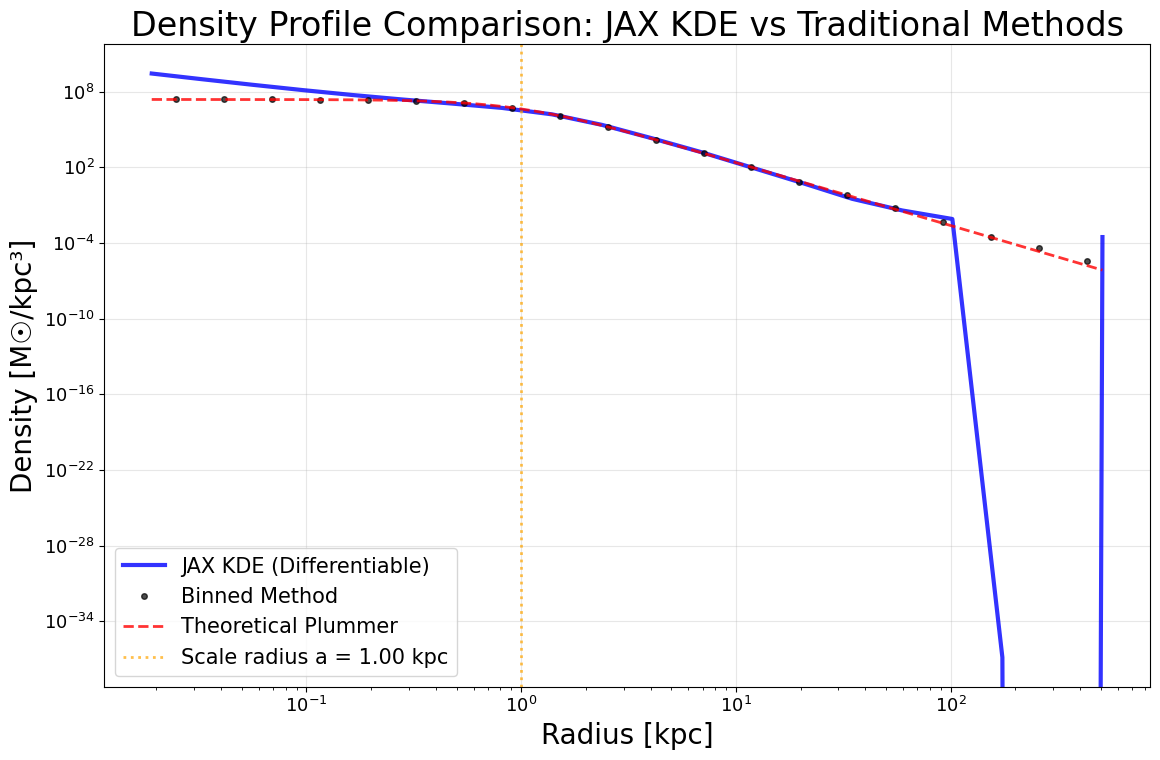

In [43]:
def compare_kde_methods(final_snapshot, mass, code_units, params):
    """Compare JAX KDE with theoretical profile and binned method"""
    
    # Method 1: JAX KDE (differentiable)
    r_kde, density_kde, kde_obj = differentiable_density_profile_jax_kde(
        final_snapshot, mass, code_units, n_eval=20, bw_method='scott'
    )
    
    # Method 2: Traditional binning (for comparison)
    r_binned, density_binned, _ = calculate_radial_density_profile(
        final_snapshot, mass, code_units, n_bins=20
    )
    
    # Method 3: Theoretical Plummer profile
    def plummer_density(r, M_total, a):
        rho_0 = (3 * M_total) / (4 * jnp.pi * a**3)
        return rho_0 * (1 + (r/a)**2)**(-5/2)
    
    M_total_phys = (params.Plummer_params.Mtot * code_units.code_mass).to(u.Msun)
    a_phys = (params.Plummer_params.a * code_units.code_length).to(u.kpc)
    
    r_theory = jnp.logspace(jnp.log10(r_kde[0].value), jnp.log10(r_kde[-1].value), 200) * u.kpc
    density_theory = plummer_density(r_theory.value, M_total_phys.value, a_phys.value) * u.Msun / u.kpc**3
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all methods
    ax.loglog(r_kde, density_kde, 'b-', linewidth=3, label='JAX KDE (Differentiable)', alpha=0.8)
    ax.loglog(r_binned, density_binned, 'ko', markersize=4, label='Binned Method', alpha=0.7)
    ax.loglog(r_theory, density_theory, 'r--', linewidth=2, label='Theoretical Plummer', alpha=0.8)
    
    # Mark the scale radius
    ax.axvline(a_phys.value, color='orange', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Scale radius a = {a_phys:.2f}')
    
    ax.set_xlabel('Radius [kpc]')
    ax.set_ylabel('Density [M☉/kpc³]')
    ax.set_title('Density Profile Comparison: JAX KDE vs Traditional Methods')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return r_kde, density_kde, kde_obj

# Run the comparison
r_kde, density_kde, kde_obj = compare_kde_methods(initial_state, mass, code_units, params)

In [14]:
density_kde

<Quantity [2.71980556e+009, 2.22697123e+009, 1.82459461e+009,
           1.49596390e+009, 1.22746552e+009, 1.00800859e+009,
           8.28556546e+008, 6.81745754e+008, 5.61575001e+008,
           4.63152727e+008, 3.82491201e+008, 3.16338939e+008,
           2.62044252e+008, 2.17444122e+008, 1.80773719e+008,
           1.50592701e+008, 1.25725198e+008, 1.05210912e+008,
           8.82652948e+007, 7.42470962e+007, 6.26319237e+007,
           5.29906938e+007, 4.49720675e+007, 3.82881307e+007,
           3.27027173e+007, 2.80218878e+007, 2.40861638e+007,
           2.07641997e+007, 1.79476303e+007, 1.55468879e+007,
           1.34878248e+007, 1.17090114e+007, 1.01596129e+007,
           8.79776642e+006, 7.58939455e+006, 6.50739230e+006,
           5.53110445e+006, 4.64597402e+006, 3.84318727e+006,
           3.11908927e+006, 2.47413498e+006, 1.91123065e+006,
           1.43354269e+006, 1.04216558e+006, 7.34283387e+005,
           5.02435537e+005, 3.35167212e+005, 2.18889824e+005,
        

In [16]:
def differentiable_density_profile_softbins(positions, mass, r_bins, temperature=0.01):
    """
    Differentiable density profile using soft binning with sigmoid functions
    
    Parameters:
    -----------
    positions : array (N_particles, 3)
        Particle positions
    mass : array (N_particles,)
        Particle masses  
    r_bins : array (N_bins + 1,)
        Radial bin edges
    temperature : float
        Controls sharpness of soft assignment (smaller = sharper)
    
    Returns:
    --------
    r_centers : array (N_bins,)
        Bin centers
    density : array (N_bins,)
        Density in each bin
    """
    
    # Calculate particle radii
    radii = jnp.linalg.norm(positions, axis=1)
    
    n_bins = len(r_bins) - 1
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Soft assignment to bins using sigmoid functions
    def soft_bin_assignment(r_particle, r_bins, temperature):
        """Soft assignment of particle to bins"""
        
        # Probability of being in each bin using sigmoid transitions
        left_edges = r_bins[:-1]
        right_edges = r_bins[1:]
        
        # Sigmoid functions for smooth transitions
        p_right = jax.nn.sigmoid((r_particle - left_edges) / temperature)
        p_left = jax.nn.sigmoid((right_edges - r_particle) / temperature)
        
        # Probability of being in bin i is p_right[i] * p_left[i]
        bin_probs = p_right * p_left
        
        # Normalize to ensure sum = 1
        bin_probs = bin_probs / (jnp.sum(bin_probs) + 1e-10)
        
        return bin_probs
    
    # Calculate mass in each bin
    mass_in_bin = jnp.zeros(n_bins)
    
    for i, (r_i, m_i) in enumerate(zip(radii, mass)):
        bin_weights = soft_bin_assignment(r_i, r_bins, temperature)
        mass_in_bin = mass_in_bin + m_i * bin_weights
    
    # Calculate bin volumes
    bin_volumes = (4.0 * jnp.pi / 3.0) * (r_bins[1:]**3 - r_bins[:-1]**3)
    
    # Calculate density
    density = mass_in_bin / bin_volumes
    
    return r_centers, density

# Usage:
r_bins = jnp.logspace(jnp.log10(0.01), jnp.log10(10), 21)  # 20 bins
r_centers, density_soft = differentiable_density_profile_softbins(
    positions, mass, r_bins, temperature=0.05
)

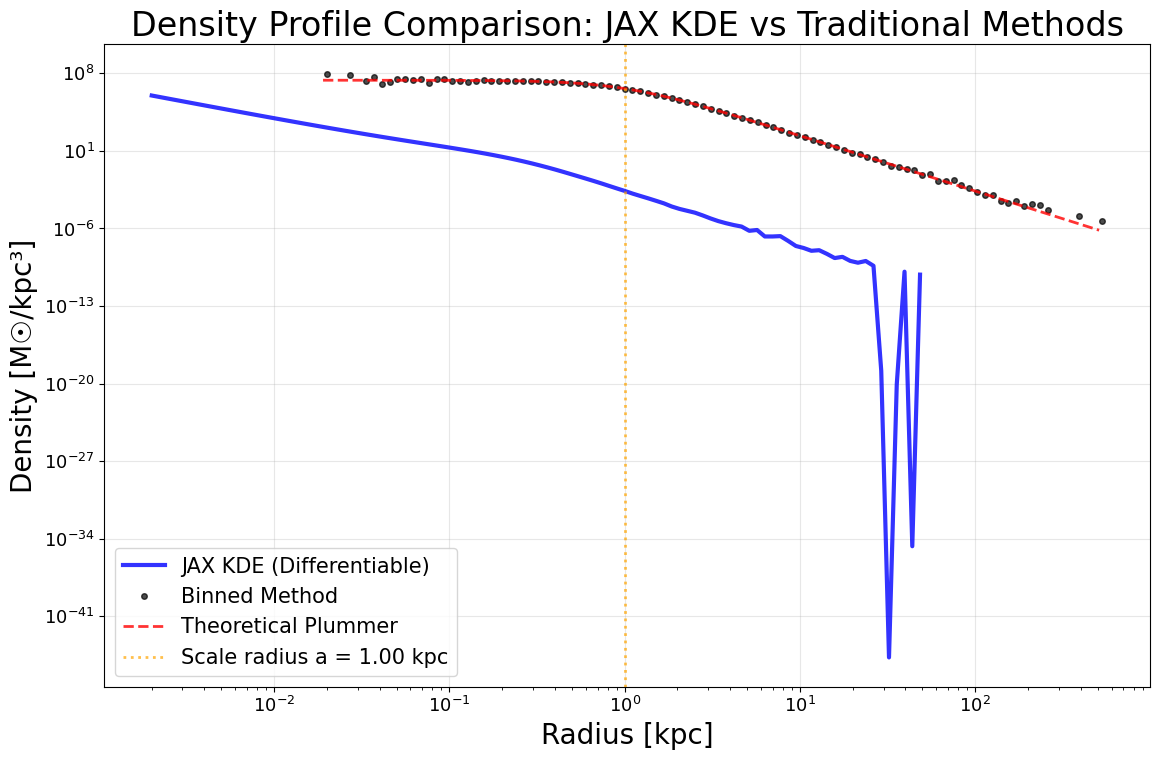

In [18]:
def compare_kde_methods(final_snapshot, mass, code_units, params):
    """Compare JAX KDE with theoretical profile and binned method"""
    
    positions = final_snapshot[:, 0]
    radii = jnp.linalg.norm(positions, axis=1)  # Shape: (N_particles,)
    r_bins = jnp.logspace(jnp.log10(jnp.min(radii)), jnp.log10(jnp.max(radii)), 100 + 1)
    # Method 1: JAX KDE (differentiable)
    r_centers, density_soft = differentiable_density_profile_softbins(
        positions, mass, r_bins, temperature=0.05
    )

    # Method 2: Traditional binning (for comparison)
    r_binned, density_binned, _ = calculate_radial_density_profile(
        final_snapshot, mass, code_units, n_bins=100
    )
    
    # Method 3: Theoretical Plummer profile
    def plummer_density(r, M_total, a):
        rho_0 = (3 * M_total) / (4 * jnp.pi * a**3)
        return rho_0 * (1 + (r/a)**2)**(-5/2)
    
    M_total_phys = (params.Plummer_params.Mtot * code_units.code_mass).to(u.Msun)
    a_phys = (params.Plummer_params.a * code_units.code_length).to(u.kpc)
    
    r_theory = jnp.logspace(jnp.log10(r_kde[0].value), jnp.log10(r_kde[-1].value), 200) * u.kpc
    density_theory = plummer_density(r_theory.value, M_total_phys.value, a_phys.value) * u.Msun / u.kpc**3
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all methods
    ax.loglog(r_centers, density_soft, 'b-', linewidth=3, label='JAX KDE (Differentiable)', alpha=0.8)
    ax.loglog(r_binned, density_binned, 'ko', markersize=4, label='Binned Method', alpha=0.7)
    ax.loglog(r_theory, density_theory, 'r--', linewidth=2, label='Theoretical Plummer', alpha=0.8)
    
    # Mark the scale radius
    ax.axvline(a_phys.value, color='orange', linestyle=':', alpha=0.7, linewidth=2,
               label=f'Scale radius a = {a_phys:.2f}')
    
    ax.set_xlabel('Radius [kpc]')
    ax.set_ylabel('Density [M☉/kpc³]')
    ax.set_title('Density Profile Comparison: Soft Binning vs Traditional Methods')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return r_kde, density_kde, kde_obj

# Run the comparison
r_kde, density_kde, kde_obj = compare_kde_methods(initial_state, mass, code_units, params)